-------------------------------------------------------------------------------------------------------------------
Implementation of : "Online Label Recovery for Deep Learning-based communication through Error Correcting codes"

Author : Eric Soubigou

Date : Spring 2019

-------------------------------------------------------------------------------------------------------------------

Description :  Creation of a DFE like with Deep Learning technologies

In [2]:
# Install libraries :
!pip3 install --user git+git://github.com/veeresht/CommPy.git@master
!pip3 install --user torch
!pip3 install --user matplotlib
!pip3 install --user scipy
print("================== DONE ! ==================")

  Cloning git://github.com/veeresht/CommPy.git (to revision master) to /tmp/pip-req-build-tiurz82l
  Running command git clone -q git://github.com/veeresht/CommPy.git /tmp/pip-req-build-tiurz82l
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ocmaobp/wheels/d1/6a/31/8ddc70e8eb8a1c3ad344032ed43b4ebfccc41007e8850226d0
Successfully built scikit-commpy
================== DONE ! ==================


In [3]:
## Imports
%load_ext autoreload
%autoreload 2

In [4]:

from __future__ import print_function
import matplotlib.pyplot as plt
import pickle # For saving file
import copy as cpy

# Scipy
import scipy as sp
from scipy import signal

# Numpy
import numpy as np
np.set_printoptions(precision=2)

# Random
import random

# Compy
from commpy.filters import *
import commpy as cp
## Simulation import
from commpy.channelcoding.convcode import Trellis, conv_encode, viterbi_decode
from commpy.modulation import *

# For DL libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the use of device which will be used 
if torch.cuda.is_available():
    device = torch.device('cuda')
    FloatTensor = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    FloatTensor = torch.FloatTensor


In [3]:
# Launch simulation
from MonteCarlo import *

simulation_param_dict = {
    "m_c_parameters": {
        "min_error_frame": 100,
        "targeted_fer": 5e-3,
        "step_db": 2,
        "min_eb_n0": 0,
        "max_eb_n0": 50,
    },
    "channel_parameters": {
        "non_lin_coeff": 0,
        "iq_imbalance": None,
        "channel_taps": np.array([1, 2, 3, 2, 1]),
    },
    "frame_length": 256,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "ZF",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
}

# Launch the simulation
monte_carlo_simulation(simulation_param_dict)

rho value is  0.5


/home/eric/.local/lib/python3.6/site-packages/commpy/modulation.py:77: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  index_list))


KeyboardInterrupt: 

[4.57e-01 4.16e-01 3.55e-01 3.04e-01 2.68e-01 2.30e-01 1.83e-01 1.41e-01
 1.05e-01 7.71e-02 6.13e-02 4.79e-02 3.89e-02 3.29e-02 2.83e-02 2.26e-02
 1.52e-02 1.03e-02 7.56e-03 1.82e-03 8.70e-05 0.00e+00 0.00e+00 0.00e+00
 0.00e+00]


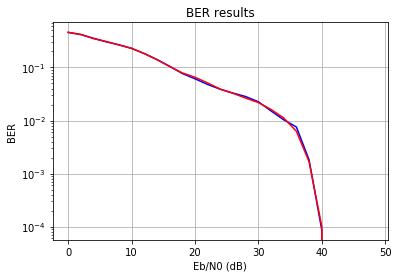

In [2]:
# Print of performances
from Utils import *


res = load_results("./results/OFDM_eq_MMSE_coding_1_non_lin_coeff_0_iq_im_None_snr_0_to_50_step_2.pickle");
#OFDM_eq_MMSE_non_lin_coeff_0_iq_im_None_snr_0_to_40_step_2.pickle")
res_ZF = load_results("./results/OFDM_eq_ZF_coding_1_non_lin_coeff_0_iq_im_None_snr_0_to_50_step_2.pickle");
#OFDM_eq_ZF_non_lin_coeff_0_iq_im_None_snr_0_to_40_step_2.pickle")

print(res["results"]["ber"])

plt.plot(res["results"]["eb_n0_db"], res["results"]["ber"], "b")
plt.plot(res_ZF["results"]["eb_n0_db"], res_ZF["results"]["ber"], "r")
plt.yscale("log")
plt.title("BER results")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(True)
plt.show()


In [190]:
from DataSetManager import *

# Data set Creation
data_set_generation_param_dict = {
    "eb_n0_db": 10,
    "channel_parameters": {
        "non_lin_coeff": 0.5,
        "iq_imbalance": 0.5,
        "channel_taps": np.array([1]),
    },
    "frame_length": 2000140, # 1000040
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
}

create_data_set(data_set_generation_param_dict)

shape comparison samples and targets (35160, 72) (35160, 72)
Data set created at ./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_10_proakis_C.pt


28128 3516 3516 35160
Epoch 100/100; training MSE : 0.00020544035942293704; validation MSE : 0.00036887067835778

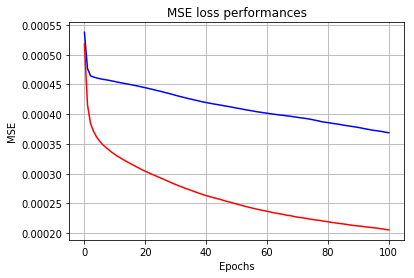

In [192]:
#  Train the NN-prequlizer
from PreEqualizer import *
from torch.utils.data import DataLoader

# Load the data set
data_set = OFDMSamplesDataset(
    "./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_10_proakis_C.pt"
)
# Spliting policies 
training_size = int(0.8 * len(data_set))
validation_size = int(0.1 * len(data_set))
test_size = int(0.1 * len(data_set))

print(
    training_size,
    validation_size,
    test_size,
    len(data_set)
)

# Split data set
training_set, validation_set, test_set = torch.utils.data.random_split(
    data_set, [training_size, validation_size, test_size]
)

# Create a data loaders.
training_dataloader = DataLoader(dataset=training_set, batch_size=2000, shuffle=False)
validation_dataloader = DataLoader(dataset=validation_set, batch_size=2000, shuffle=False)

# Creation of the PreEqualizer
model_path = "./models/pre_eq_model_test_1"

pre_eq_loaded = PreEqualizer(data_set.get_number_of_carriers())
try:
    pre_eq_loaded.load_state_dict(torch.load(model_path))
except:
    print("Error, can't load {} => Generate a new model".format(model_path))
    pre_eq = PreEqualizer(data_set.get_number_of_carriers())

# Train the Pre-Equalizer in standalone mode
PreEqualizer.train(pre_eq, training_dataloader, validation_dataloader, nb_epochs=100, sgd_step=0.001)

# Perform the 

# Save the model after training
torch.save(pre_eq.state_dict(), model_path)

In [159]:
# Test the performances of the model
# Create a data loader.
test_dataloader = DataLoader(dataset=test_set, batch_size=1000, shuffle=False)

# Model loading
model_path = "./models/pre_eq_model_test"

pre_eq_loaded = PreEqualizer(data_set.get_number_of_carriers())
try:
    pre_eq_loaded.load_state_dict(torch.load(model_path))
except:
    pre_eq = PreEqualizer(data_set.get_number_of_carriers())

# Train the Pre-Equalizer in standalone mode
PreEqualizer.train(pre_eq, test_dataloader, nb_epochs=100, sgd_step=0.001)


Epoch 100/100; MSE : 0.000650811183732003